<a href="https://colab.research.google.com/github/KiykoHanna/Stepik-DeepLearning/blob/main/%5Bhw%5Dsemantic_segmentation-easy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




In [ ]:
!wget -c https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2023-04-23 10:45:08--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2023-04-23 10:45:08--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce5f72e20c9991ee19853e2f37c.dl.dropboxusercontent.com/cd/0/inline/B6tYjRQ7_r9aQVjAOF3kMlowhJvpTh-zVbcOeq1QnTXY0YZLs9pe8jaqC-LV_AOmazfFpV3Iwm1OzOE_flOoL70-_r-KUsKLdYCAfrIN7z4_QxVnROv1jzOBFBZkMW96XxRSKjVNfcA_VBD__CGyxSfOEDCPEFkmR2BpTp3LBTfAWQ/file# [following]
--2023-04-23 10:45:09--  https://uce5f72e20c9991ee19853e2f37c.dl.dropboxusercontent.com/cd/0/inline/B6tYjRQ7_r9aQVjAOF3kMlowhJvpTh-zVbcOeq1QnTXY0YZLs9pe8jaqC-LV_AOmazfFpV3Iwm

In [ ]:
!ls

PH2Dataset.rar	sample_data


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("grayscale")
from IPython.display import clear_output


Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.enc_conv0 = nn.Sequential(*[nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(inplace=True)
                                        ])
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(*[nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(inplace=True)
                                        ])
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(*[nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                          nn.BatchNorm2d(128),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                          nn.BatchNorm2d(128),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                          nn.BatchNorm2d(128),
                                          nn.ReLU(inplace=True)
                                        ])
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(*[nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                          nn.BatchNorm2d(256),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                          nn.BatchNorm2d(256),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                          nn.BatchNorm2d(256),
                                          nn.ReLU(inplace=True)
                                        ])
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(*[nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                               nn.BatchNorm2d(512),
                                               nn.ReLU(inplace=True),
                                               nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                               nn.BatchNorm2d(256),
                                               nn.ReLU(inplace=True),
                                          
                                        ])

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2,2) # 16 -> 32
        self.dec_conv0 =  nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                                nn.ReLU(inplace=True),
                                                nn.BatchNorm2d(256),
                                                nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                                nn.ReLU(inplace=True),
                                                nn.BatchNorm2d(256),
                                                nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                                nn.ReLU(inplace=True),
                                                nn.BatchNorm2d(128)
                                               ])
        self.upsample1 = nn.MaxUnpool2d(2,2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                                nn.ReLU(inplace=True),
                                                nn.BatchNorm2d(128),
                                                nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                                nn.ReLU(inplace=True),
                                                nn.BatchNorm2d(128),
                                                nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                                nn.ReLU(inplace=True),
                                                nn.BatchNorm2d(64)
                                               ])
        self.upsample2 = nn.MaxUnpool2d(2,2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                                nn.ReLU(inplace=True),
                                                nn.BatchNorm2d(64),
                                                nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
                                                nn.ReLU(inplace=True),
                                                nn.BatchNorm2d(32)
                                               ])
        self.upsample3 = nn.MaxUnpool2d(2,2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(*[       
                                                nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                                nn.ReLU(inplace=True),
                                                nn.BatchNorm2d(32),
                                                nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
                                              ])

    def forward(self, x):
        # encoder
        x = self.enc_conv0(x)
        x, indices0 = self.pool0(x)
        x = self.enc_conv1(x)
        x, indices1 = self.pool0(x)
        x = self.enc_conv2(x)
        x, indices2 = self.pool0(x)
        x = self.enc_conv3(x)
        x, indices3 = self.pool0(x)

        # bottleneck
        b = self.bottleneck_conv(x)

        # decoder
        x = self.upsample0(b, indices3)
        x = self.dec_conv0(x)
        x = self.upsample1(x, indices2)
        x = self.dec_conv1(x)
        x = self.upsample2(x,  indices1)
        x = self.dec_conv2(x)
        x = self.upsample3(x,  indices0)
        x = self.dec_conv3(x)
        return x

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1).byte() # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**


$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    loss = y_pred - (y_pred * y_real) + torch.log(1 + torch.exp(-1 * y_pred))
    return torch.mean(loss)


## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
import time
import copy
import gc

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, sheduler, score_fn):
    X_val, Y_val = next(iter(data_val))
    loss_t = []
    loss_v = []
    score_v = []
    score_t = []
    
    
    for epoch in range(epochs):
        
        print('* Epoch %d/%d' % (epoch+1, epochs))
        av_loss = 0

        # train mode
        model.train()  
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
           
            # calculate loss to show the user
            av_loss += loss / len(data_tr)
        
        loss_t.append(av_loss.cpu().detach().numpy())

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().to('cpu')
        Y_pred = torch.sigmoid(Y_hat)
        Y_pred = Y_pred.to(device)
        
             
        loss_v.append(loss_fn(Y_val, Y_hat))
        av_score_t = score_fn(model, iou_pytorch, data_tr)
        score_t.append(av_score_t)
        av_score_v = score_fn(model, iou_pytorch, data_val)
        score_v.append(av_score_v)
        
        scheduler.step()
        
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            Y_pred = Y_pred.to('cpu')
            plt.imshow((Y_pred[k, 0]), cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, av_loss))
        plt.show()

    return loss_t, loss_v, score_v, score_t

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    # testing mode
    model.eval()  
    scores = 0
    for X_batch, Y_label in data:
      Y_pred = torch.sigmoid(model(X_batch.to(device)))
      Y_pred = Y_pred > 0.5
      scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


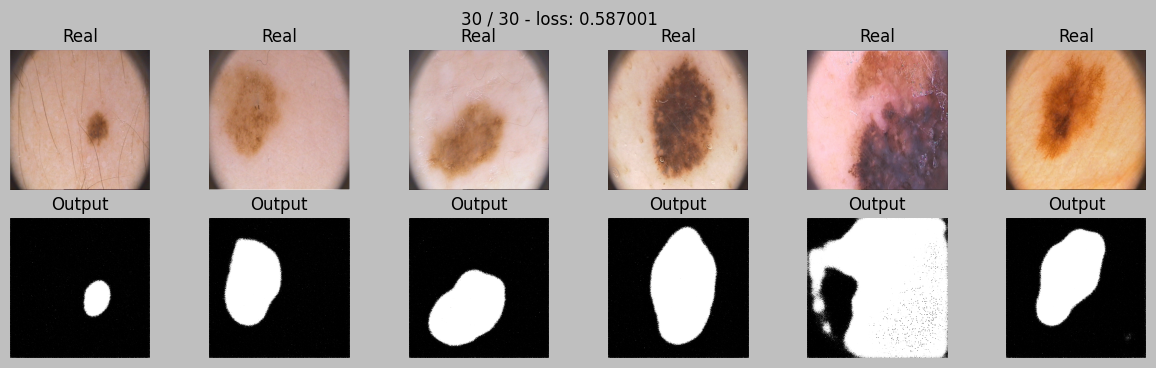

In [ ]:
model_bce = SegNet().to(device)

max_epochs = 30
optim = torch.optim.Adam(model_bce.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.95)
loss_t_bce, loss_v_bce, score_v_bce, score_t_bce = train(model_bce, optim, bce_loss, max_epochs, data_tr, data_val, scheduler, score_model)

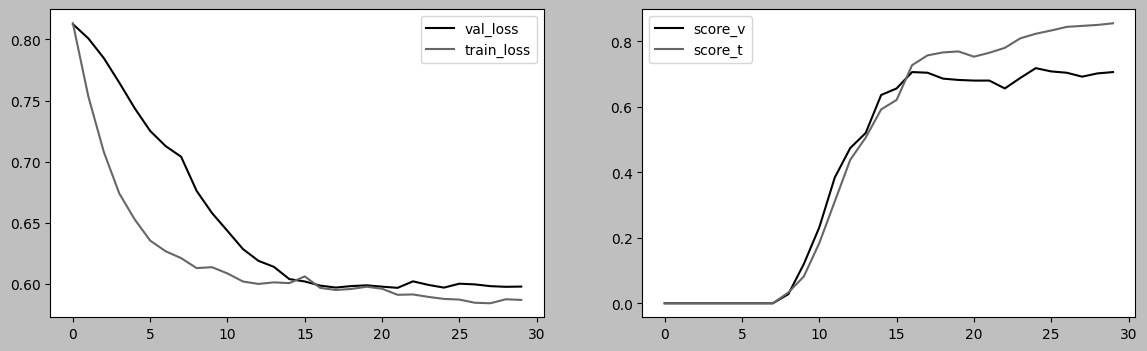

 score на валидационной выборке : 0.7180000245571136


In [ ]:

fig = plt.figure(figsize = (14, 4))
ax1 = fig.add_subplot(121)
plt.plot(loss_v_bce, label="val_loss",)
plt.plot(loss_t_bce, label="train_loss",)
plt.legend()
ax1 = fig.add_subplot(122)
plt.plot(score_v_bce, label="score_v", )
plt.plot(score_t_bce, label="score_t",)
plt.legend()
plt.show()

score_Sn_bce = max(score_v_bce)

print(f' score на валидационной выборке : {score_Sn_bce}')

К сожалению, на графике мы видим тенденцию к переобучению.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** 

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):
   
  y_pred = torch.flatten(torch.sigmoid(y_pred))
  y_real = torch.flatten(y_real)
  numerator = 2 * torch.sum(y_real * y_pred)
  denominator = torch.sum(y_real + y_pred)
  loss = 1 - (numerator / denominator)

  return torch.mean(loss) 
 

Проводим тестирование:

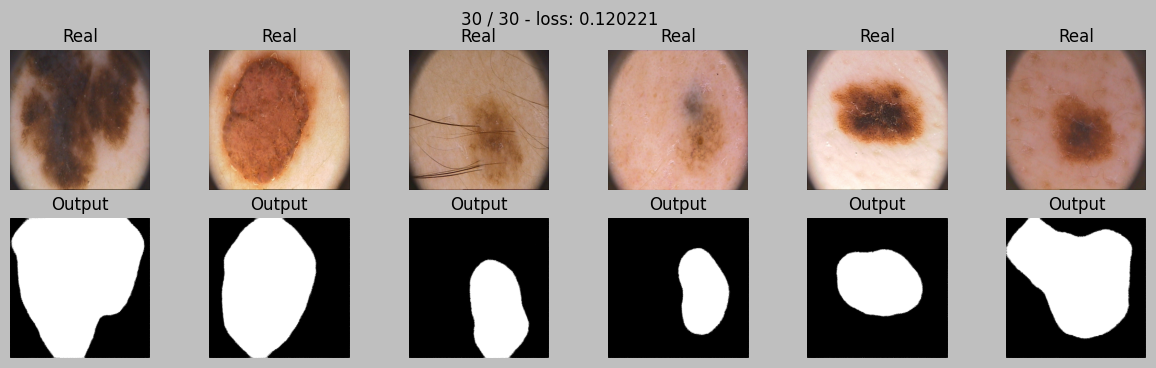

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 30
optim = torch.optim.Adam(model_dice.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.80)
loss_t_dice, loss_v_dice, score_v_dice, score_t_dice = train(model_dice, optim, dice_loss, max_epochs, data_tr, data_val, scheduler, score_model)


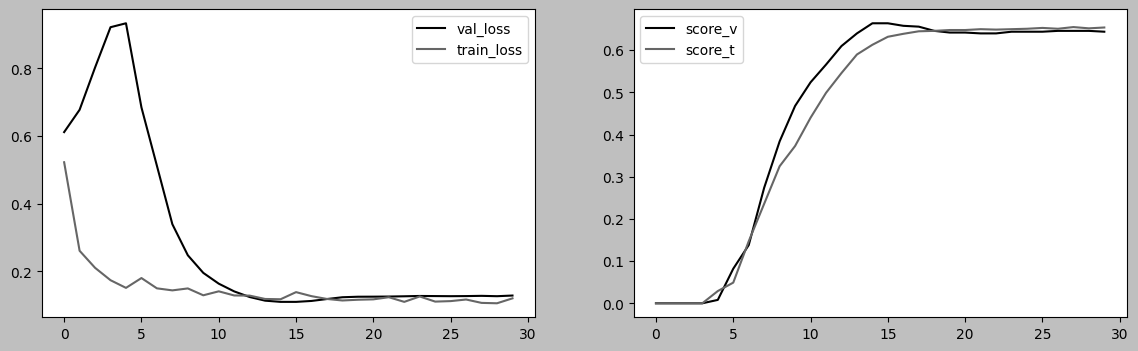

 score на валидационной выборке : 0.664000004529953


In [ ]:
fig = plt.figure(figsize = (14, 4))
ax1 = fig.add_subplot(121)
plt.plot(loss_v_dice, label="val_loss")
plt.plot(loss_t_dice, label="train_loss")
plt.legend()
ax1 = fig.add_subplot(122)
plt.plot(score_v_dice, label="score_v",  )
plt.plot(score_t_dice, label="score_t",)
plt.legend()
plt.show()

score_Sn_dice = score = max(score_v_dice)
print(f' score на валидационной выборке : {score_Sn_dice}')

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 



$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, e=0.0001, gamma=2):
  y_pred = torch.sigmoid(y_pred)
  y_pred = torch.unsqueeze(y_pred, 1)
  y_real = torch.unsqueeze(y_real, 1) 
  loss = ((1 - torch.sigmoid(y_pred)) ** gamma) * y_real * torch.log(torch.sigmoid(y_pred) + e) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred) + e)
  return (-1)*torch.mean(loss)

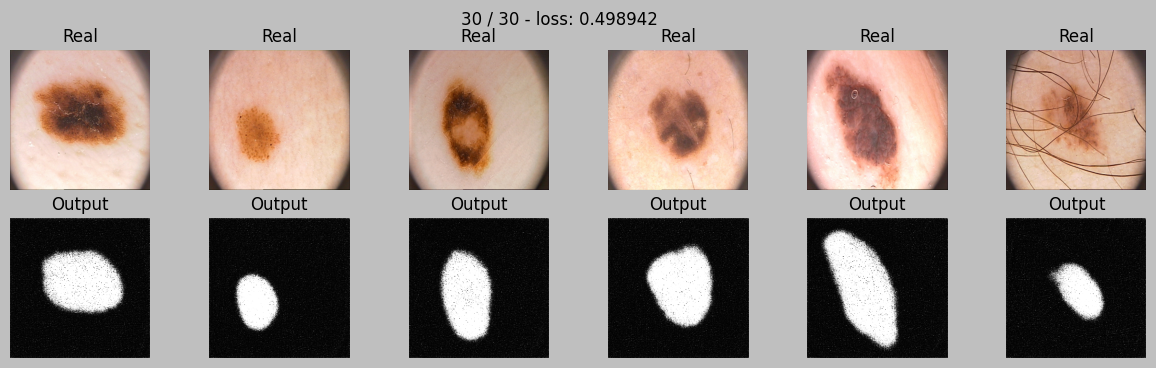

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 30
optim = torch.optim.Adam(model_focal.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.85)
loss_t_focal, loss_v_focal, score_v_focal, score_t_focal = train(model_focal, optim, focal_loss, max_epochs, data_tr, data_val, scheduler,  score_model )


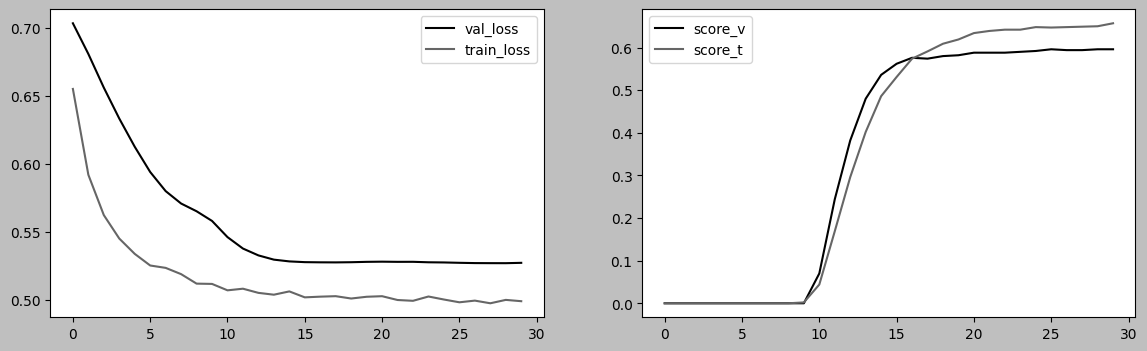

лучший score на валидационной выборке : 0.5960000157356262


In [ ]:
fig = plt.figure(figsize = (14, 4))
ax1 = fig.add_subplot(121)
plt.plot(loss_v_focal, label="val_loss")
plt.plot(loss_t_focal, label="train_loss")
plt.legend()
ax1 = fig.add_subplot(122)
plt.plot(score_v_focal, label="score_v")
plt.plot(score_t_focal, label="score_t")
plt.legend()
plt.show()
score_Sn_focal = max(score_v_focal)
print(f'лучший score на валидационной выборке : {score_Sn_focal}')

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]


# Hausdorff Distance Loss



Hausdorff Distance (HD) is a metric used by segmentation
approaches to track the performance of a model. It is defined
as:

d(X, Y ) = maxxX minyY ||x − y||2

In [ ]:
import cv2
from scipy.ndimage.morphology import distance_transform_edt as edt
from scipy.ndimage import convolve

<ipython-input-41-d97c59ad906c>:2: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt as edt


In [ ]:
class HausdorffLoss(nn.Module):
    def __init__(self, alpha=2.0, **kwargs):
        super(HausdorffLoss, self).__init__()
        self.alpha = alpha

    @torch.no_grad()
    def distance_field(self, img: np.ndarray) :
        field = np.zeros_like(img)

        for batch in range(len(img)):
            fg_mask = img[batch] > 0.5
            if fg_mask.any():
                bg_mask = ~fg_mask
                fg_dist = edt(fg_mask)
                bg_dist = edt(bg_mask)
                field[batch] = fg_dist + bg_dist

        return field

    def forward(self, target: torch.Tensor, pred: torch.Tensor, debug=False) :
        pred = torch.sigmoid(pred)
        pred_dt = torch.from_numpy(self.distance_field(pred.detach().cpu().numpy())).float()
        target_dt = torch.from_numpy(self.distance_field(target.detach().cpu().numpy())).float()

        pred_error = (pred - target) ** 2
        distance = pred_dt ** self.alpha + target_dt ** self.alpha

        dt_field = pred_error.to(device) * distance.to(device)
        loss = dt_field.mean()

        return loss

hausdor_loss = HausdorffLoss()

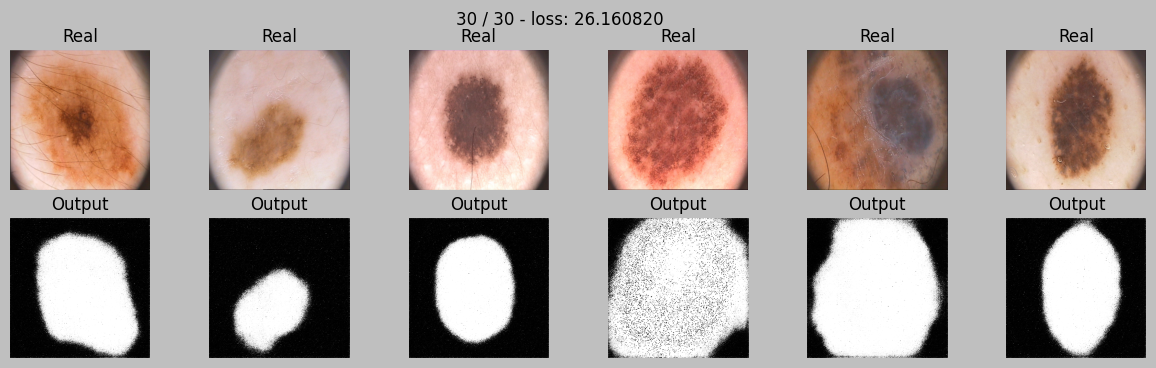

In [ ]:
model_hausdor = SegNet().to(device)
max_epochs = 30
optim = torch.optim.Adam(model_hausdor.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2, gamma=0.85)
hausdor_loss = HausdorffLoss()
loss_t_hausdor, loss_v_hausdor, score_v_hausdor, score_t_hausdor = train(model_hausdor, optim, hausdor_loss, max_epochs, data_tr, data_val, scheduler,  score_model )

### Отнормируем лосс исключительно для удобства визуального сравнения

In [ ]:
loss_v_hausdor = [(i/max(loss_v_hausdor)) for i in loss_v_hausdor]
loss_t_hausdor = [(i/max(loss_t_hausdor)) for i in loss_t_hausdor]

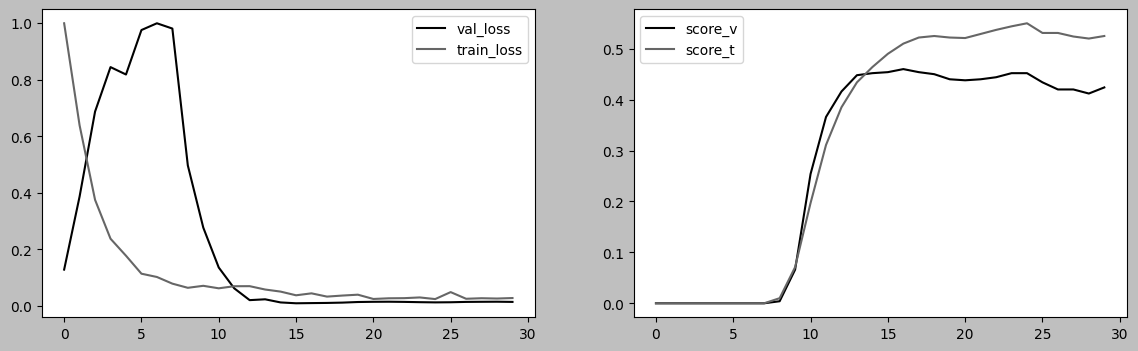

лучший score на валидационной выборке : 0.46000000834465027


In [ ]:
fig = plt.figure(figsize = (14, 4))
ax1 = fig.add_subplot(121)
plt.plot(loss_v_hausdor, label="val_loss")
plt.plot(loss_t_hausdor, label="train_loss")
plt.legend()
ax1 = fig.add_subplot(122)
plt.plot(score_v_hausdor, label="score_v")
plt.plot(score_t_hausdor, label="score_t")
plt.legend()
plt.show()
score_Sn_hausdor = max(score_v_hausdor)
print(f'лучший score на валидационной выборке : {score_Sn_hausdor}')

# Tversky loss function

Tversky index (TI) [11] can also be seen as an generalization
of Dices coefficient. It adds a weight to FP (false positives)
and FN (false negatives) with the help of β coefficient.

T I(p, ˆp) = pˆp
pˆp + β(1 − p)ˆp + (1 − β)p(1 − ˆp) 
Here, when β = 1/2, It can be solved into regular Dice
coefficient. Similar to Dice Loss, Tversky loss can also be
defined as:

T L(p, ˆp) = 1− 1 + pˆp
1 + pˆp + β(1 − p)ˆp + (1 − β)p(1 − ˆp) 

In [ ]:
class Tversky(nn.Module):

    def __init__(self, alpha=0.3, beta=0.7, ignore_index=None, reduction='mean'):
        super(Tversky, self).__init__()
        
        self.alpha = alpha
        self.beta = beta
        self.ignore_index = ignore_index
        self.smooth = 10
        self.reduction = reduction
        s = self.beta + self.alpha
        if s != 1:
            self.beta = self.beta / s
            self.alpha = self.alpha / s

    def forward(self, target, output, mask=None):
        batch_size = output.size(0)
        bg_target = 1 - target
        if self.ignore_index is not None:
            valid_mask = (target != self.ignore_index).float()
            output = output.float().mul(valid_mask) 
            target = target.float().mul(valid_mask)
            bg_target = bg_target.float().mul(valid_mask)

        output = torch.sigmoid(output).view(batch_size, -1)
        target = target.view(batch_size, -1)
        bg_target = bg_target.view(batch_size, -1)

        P_G = torch.sum(output * target, 1) 
        P_NG = torch.sum(output * bg_target, 1) 
        NP_G = torch.sum((1 - output) * target, 1) 

        tversky_index = P_G / (P_G + self.alpha * P_NG + self.beta * NP_G + self.smooth)

        loss = 1. - tversky_index
        
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        else:
            loss = torch.mean(loss)
        return loss

tversky_loss = Tversky()

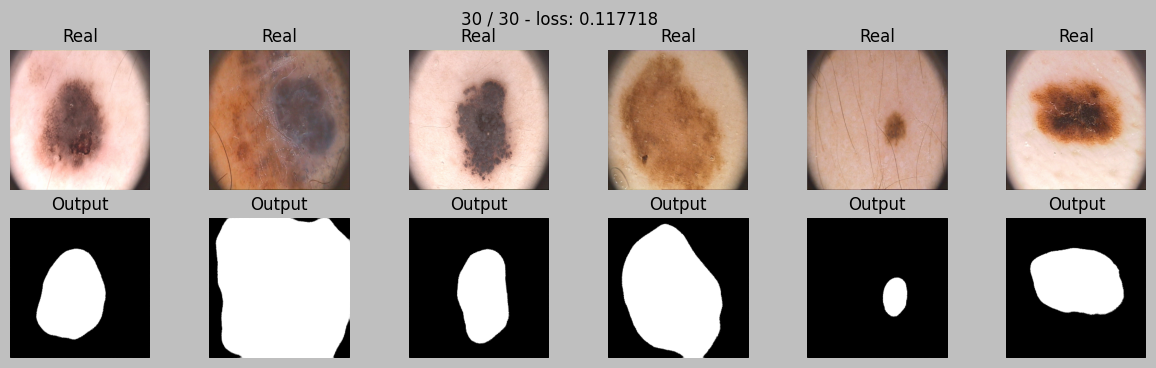

In [ ]:
model_tversky = SegNet().to(device)

max_epochs = 30
optim = torch.optim.Adam(model_tversky.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2, gamma=0.85)

loss_t_tversky, loss_v_tversky, score_v_tversky, score_t_tversky = train(model_tversky, optim, tversky_loss, max_epochs, data_tr, data_val, scheduler,  score_model )


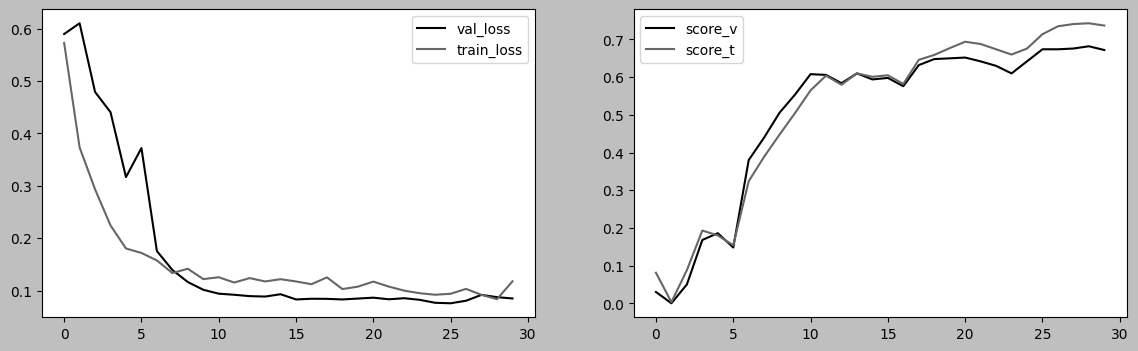

лучший score на валидационной выборке : 0.6820000112056732


In [ ]:
fig = plt.figure(figsize = (14, 4))
ax1 = fig.add_subplot(121)
plt.plot(loss_v_tversky, label="val_loss")
plt.plot(loss_t_tversky, label="train_loss")
plt.legend()
ax1 = fig.add_subplot(122)
plt.plot(score_v_tversky, label="score_v")
plt.plot(score_t_tversky, label="score_t")
plt.legend()
plt.show()
score_Sn_tversky = max(score_v_tversky)
print(f'лучший score на валидационной выборке : {score_Sn_tversky}')

# U-Net [2 балла]

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 =  nn.Sequential(*[nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(inplace=True)
                                        ])
        self.pool0 =  nn.MaxPool2d(kernel_size=2, stride=2) # 256 -> 128
        self.enc_conv1 = nn.Sequential(*[nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(inplace=True)
                                        ])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(*[nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(inplace=True)
                                        ])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(*[nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(inplace=True)
                                        ])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv =  nn.Sequential(*[
                                         nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU()
                                         ])


        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(32)# 16 -> 32
        self.dec_conv0 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=1024 + 512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                         ])
        self.upsample1 = nn.Upsample(64) # 32 -> 64
        self.dec_conv1 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=256 + 512, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                         ])
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=256 + 128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                         ])
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=64 + 128, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
                                        
                                         ])

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)
        
        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3) # no activation
        return d3

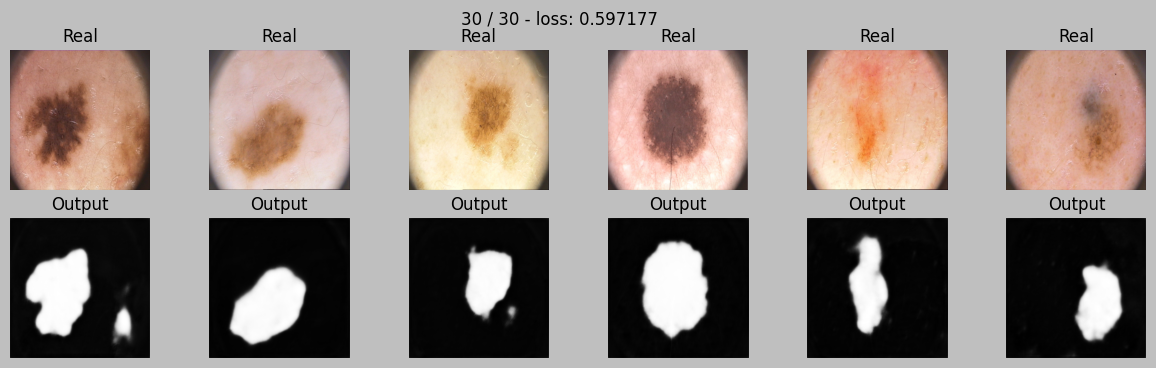

In [ ]:
unet_model = UNet().to(device)

max_epochs = 30
optim = torch.optim.Adam(unet_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.95)

loss_t_unet, loss_v_unet, score_v_unet, score_t_unet = train(unet_model, optim, bce_loss, max_epochs, data_tr, data_val, scheduler,  score_model )


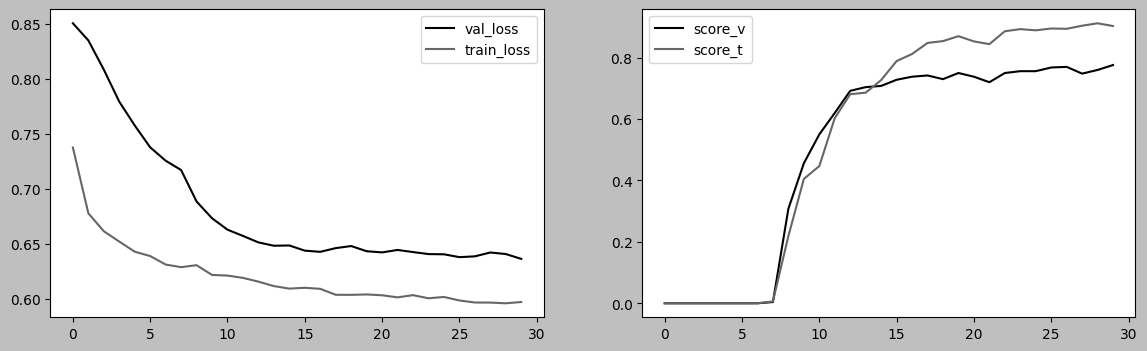

лучший score на валидационной выборке : 0.7759999632835388


In [ ]:
fig = plt.figure(figsize = (14, 4))
ax1 = fig.add_subplot(121)
plt.plot(loss_v_unet, label="val_loss")
plt.plot(loss_t_unet, label="train_loss")
plt.legend()
ax1 = fig.add_subplot(122)
plt.plot(score_v_unet, label="score_v")
plt.plot(score_t_unet, label="score_t")
plt.legend()
plt.show()
score_Un_bce = max(score_v_unet)
print(f'лучший score на валидационной выборке : {score_Un_bce}')

### Протестируем модель UNet с еще тремя лосс функциями (focal, tversky, dice), как наиболее перспективными

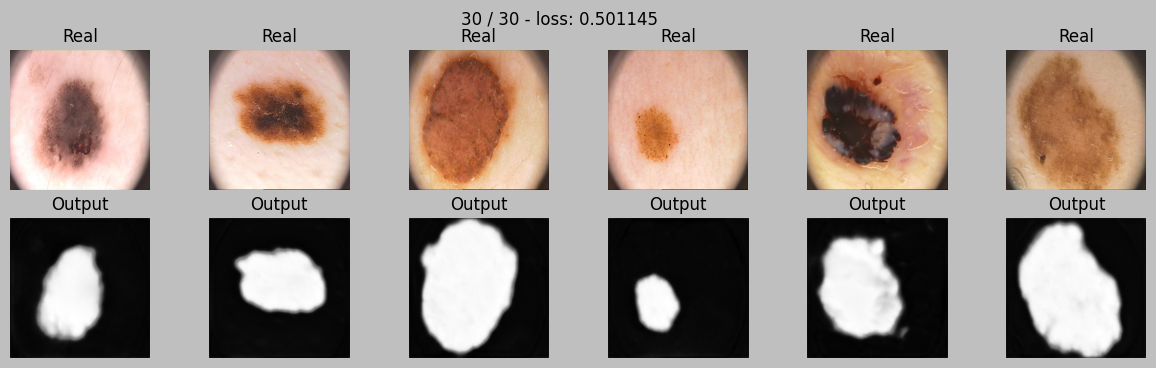

In [ ]:
unet_model = UNet().to(device)

max_epochs = 30
optim = torch.optim.Adam(unet_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.95)

loss_t_unet_focal, loss_v_unet_focal, score_v_unet_focal, score_t_unet_focal = train(unet_model, optim, focal_loss, max_epochs, data_tr, data_val, scheduler,  score_model )


In [ ]:
score_Un_focal = max(score_v_unet_focal)

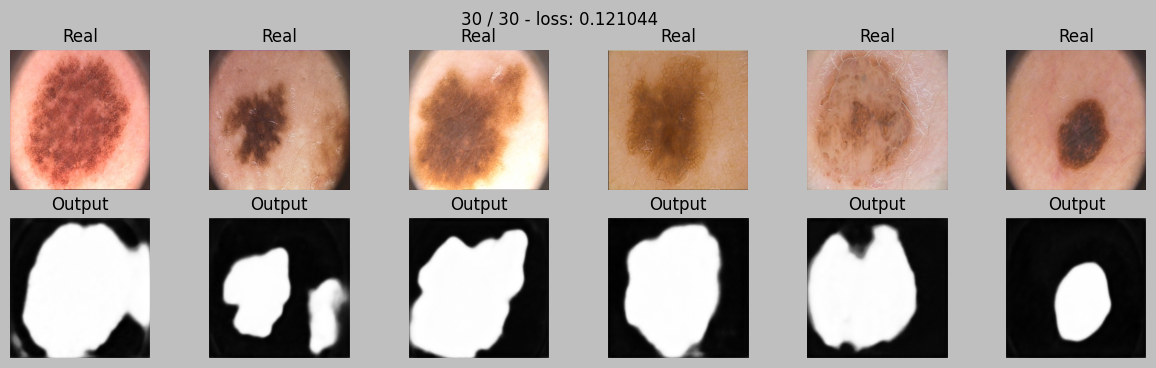

In [ ]:
unet_model = UNet().to(device)

max_epochs = 30
optim = torch.optim.Adam(unet_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.95)

loss_t_unet_dice, loss_v_unet_dice, score_v_unet_dice, score_t_unet_dice = train(unet_model, optim, dice_loss, max_epochs, data_tr, data_val, scheduler,  score_model )


In [ ]:
score_Un_dice = max(score_v_unet_dice)

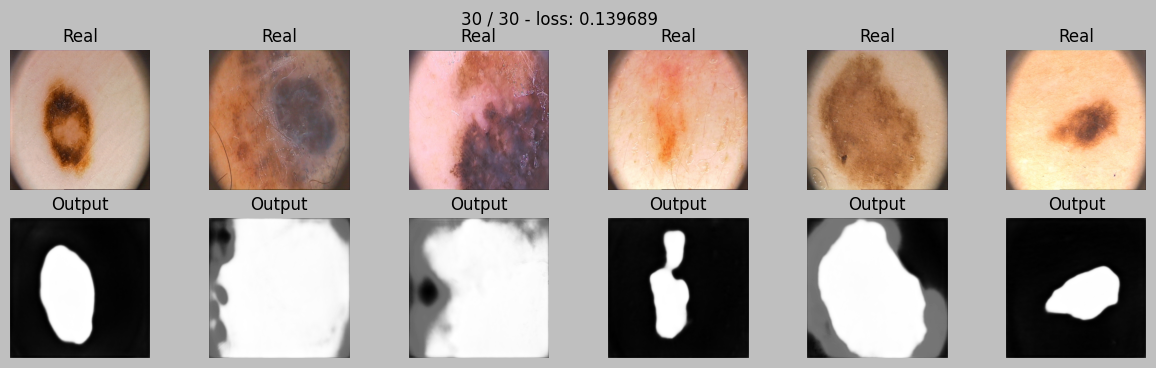

In [ ]:
unet_model = UNet().to(device)

max_epochs = 30
optim = torch.optim.Adam(unet_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.95)

loss_t_unet_tversky, loss_v_unet_tversky, score_v_unet_tversky, score_t_unet_tversky = train(unet_model, optim, tversky_loss, max_epochs, data_tr, data_val, scheduler,  score_model )

In [ ]:
score_Un_tversky = max(score_v_unet_tversky)

# U-Net2
Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
  def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 =  nn.Sequential(*[nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(inplace=True)
                                        ])
        self.pool0 =  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)   # 256 -> 128

        self.enc_conv1 = nn.Sequential(*[nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(inplace=True)
                                        ])
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(*[nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(inplace=True)
                                        ])
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(*[nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(inplace=True)
                                        ])
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv =  nn.Sequential(*[
                                         nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU()
                                         ])


        # decoder (upsampling)
        self.upsample0 =  nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                         ])
        self.upsample1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(*[
                                         nn.Conv2d(in_channels= 512, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                         ])
        self.upsample2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=256 , out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                         ])
        self.upsample3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
                                        
                                         ])

  def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)
        
        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3) # no activation
        return d3


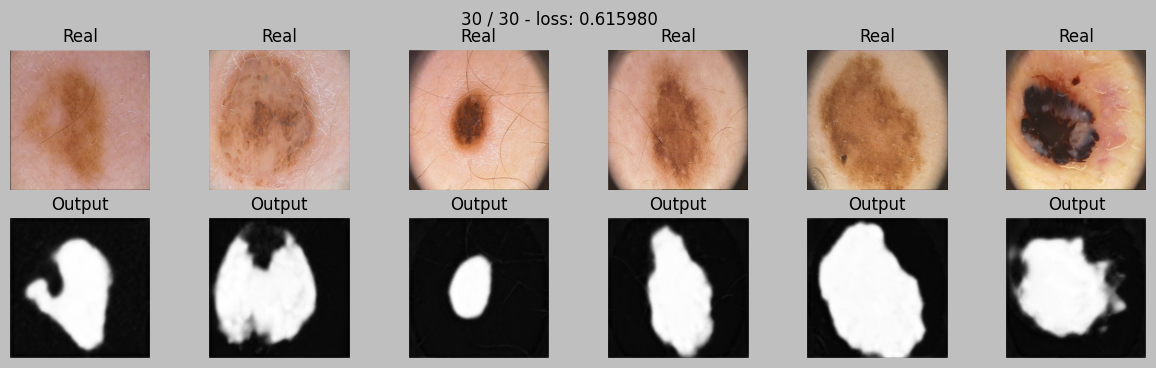

In [ ]:
unet2_model = UNet2().to(device)

max_epochs = 30
optim = torch.optim.Adam(unet2_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.95)

loss_t_unet2, loss_v_unet2, score_v_unet2, score_t_unet2 = train(unet2_model, optim, bce_loss, max_epochs, data_tr, data_val, scheduler,  score_model )


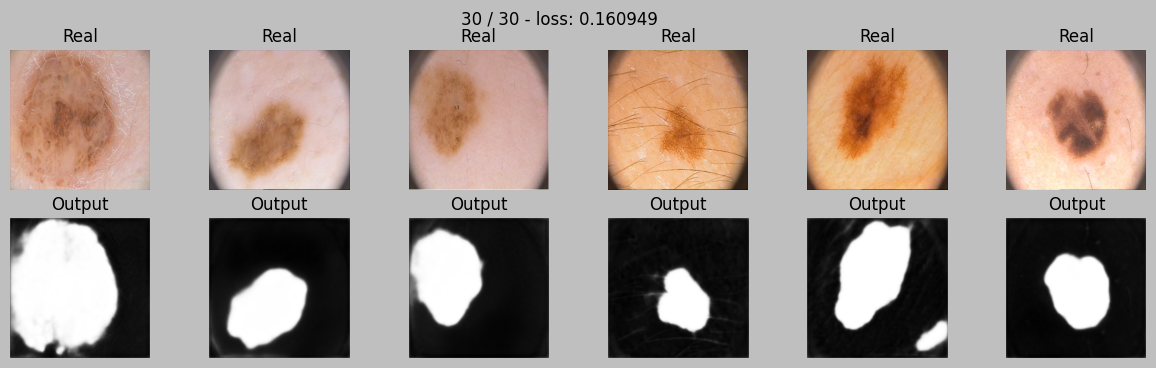

In [ ]:
unet2_model = UNet2().to(device)

max_epochs = 30
optim = torch.optim.Adam(unet2_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.95)

loss_t_unet2_tversky, loss_v_unet2_tversky, score_v_unet2_tversky, score_t_unet2_tversky = train(unet2_model, optim, tversky_loss, max_epochs, data_tr, data_val, scheduler,  score_model )

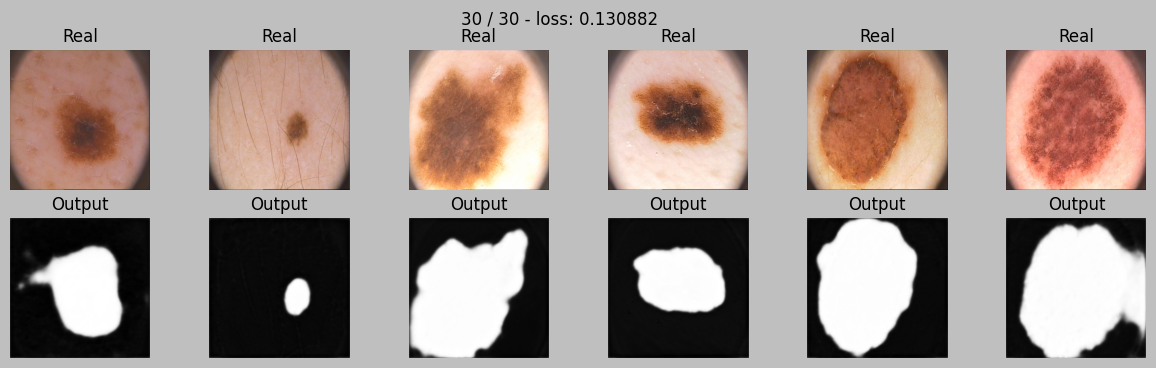

In [ ]:
unet2_model = UNet2().to(device)

max_epochs = 30
optim = torch.optim.Adam(unet2_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.95)

loss_t_unet2_dice, loss_v_unet2_dice, score_v_unet2_dice, score_t_unet2_dice = train(unet2_model, optim, dice_loss, max_epochs, data_tr, data_val, scheduler,  score_model )

In [ ]:
score_Un2_dice = max(score_v_unet2_dice)

# Отчет (6 баллов): 


# Отчет по лабораторной работе "Семантическая сегментация"

В этой работе я решала задачу сегментации медицинских снимков. Я написала несколько нейросетевых архитектур для решения задачи семантической сегментации, а именно: SegNet, U-Net, U-Net2. А так же я реализовала различные лосс функции:  Binary Cross-Entrop(bce_loss), Dice coefficient (dice_loss),  Focal loss (focal_loss), Hausdorff Distance Los(hausdor_loss), Tversky Loss(trersky_loss). 



Оценим как обучаются модели. Посмотрим на лоссы на валидации и трейне.

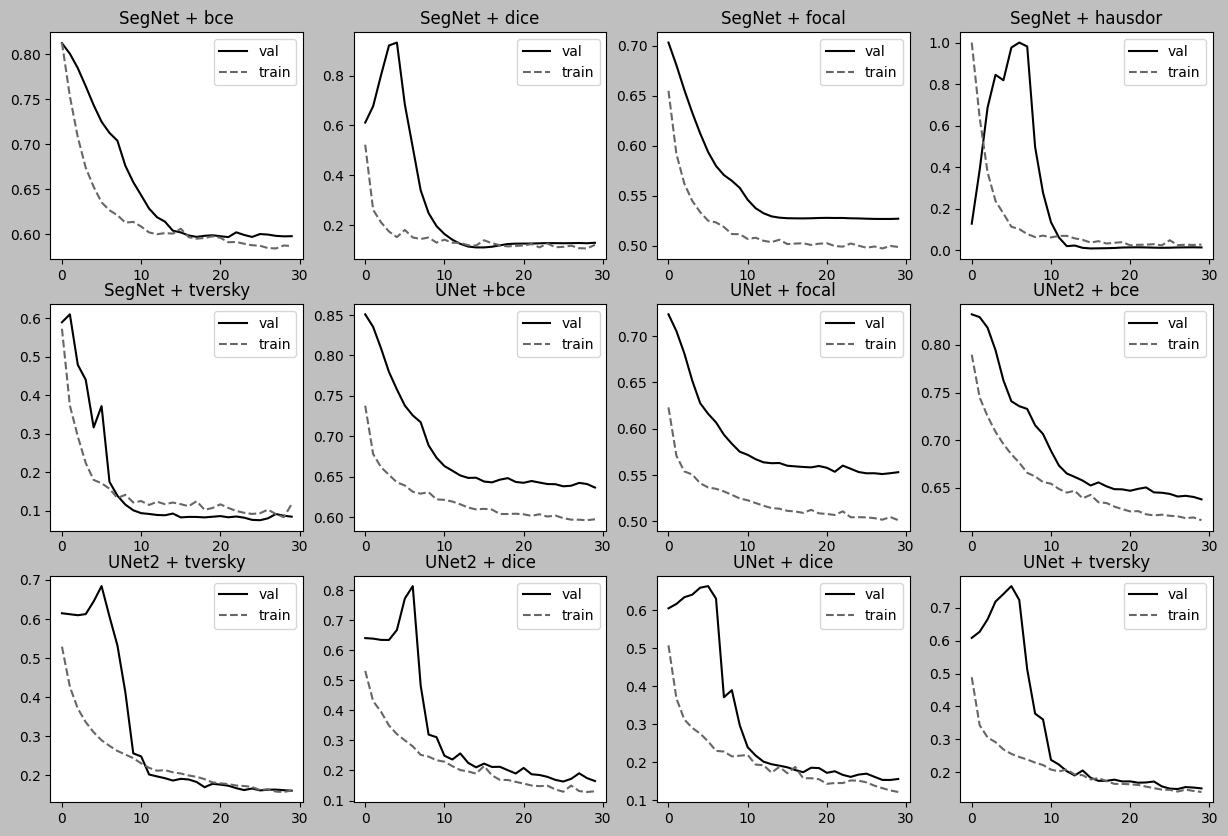

In [ ]:

fig = plt.figure(figsize = (15, 10))
ax1 = fig.add_subplot(341)
plt.plot(loss_v_bce, label="val")
plt.plot(loss_t_bce, label="train", linestyle='dashed')
ax1.set_title('SegNet + bce')
plt.legend()

ax2 = fig.add_subplot(342)
plt.plot(loss_v_dice, label="val",)
plt.plot(loss_t_dice, label="train",  linestyle='dashed')
ax2.set_title('SegNet + dice')
plt.legend()

ax3 = fig.add_subplot(343)
plt.plot(loss_v_focal, label="val", )
plt.plot(loss_t_focal, label="train", linestyle='dashed')
ax3.set_title('SegNet + focal')
plt.legend()

ax4 = fig.add_subplot(344)
plt.plot(loss_v_hausdor, label="val")
plt.plot(loss_t_hausdor, label="train", linestyle='dashed')
ax4.set_title('SegNet + hausdor')
plt.legend()

ax5 = fig.add_subplot(345)
plt.plot(loss_v_tversky, label="val", )
plt.plot(loss_t_tversky, label="train", linestyle='dashed')
ax5.set_title('SegNet + tversky')
plt.legend()

ax6 = fig.add_subplot(346)
plt.plot(loss_v_unet, label="val", )
plt.plot(loss_t_unet, label="train", linestyle='dashed')
ax6.set_title('UNet +bce')
plt.legend()

ax7 = fig.add_subplot(347)
plt.plot(loss_v_unet_focal, label="val", )
plt.plot(loss_t_unet_focal, label="train", linestyle='dashed')
ax7.set_title('UNet + focal')
plt.legend()


ax8 = fig.add_subplot(348)
plt.plot(loss_v_unet2, label="val")
plt.plot(loss_t_unet2, label="train", linestyle='dashed')
ax8.set_title('UNet2 + bce')
plt.legend()

ax9 = fig.add_subplot(349)
plt.plot(loss_v_unet2_tversky, label="val")
plt.plot(loss_t_unet2_tversky, label="train", linestyle='dashed')
ax9.set_title('UNet2 + tversky')
plt.legend()

ax10 = fig.add_subplot(3,4,10)
plt.plot(loss_v_unet2_dice, label="val")
plt.plot(loss_t_unet2_dice, label="train", linestyle='dashed')
ax10.set_title('UNet2 + dice')
plt.legend()

ax11 = fig.add_subplot(3,4,11)
plt.plot(loss_v_unet_dice, label="val")
plt.plot(loss_t_unet_dice, label="train", linestyle='dashed')
ax11.set_title('UNet + dice')
plt.legend()

ax12 = fig.add_subplot(3,4,12)
plt.plot(loss_v_unet_tversky, label="val")
plt.plot(loss_t_unet_tversky, label="train", linestyle='dashed')
ax12.set_title('UNet + tversky')
plt.legend()

plt.legend()
plt.show()

### Как мы можем видеть из графиков, все модели успешно обучаются и сходятся. Моделям с SegNet архитектурой достаточно 30 эпох для обучения, UNet модел можно попробовать учить дольше. Часть моделей проявляет признаки переобучения.

### Проведем сравнение различных лосс функций на одной модели (SegNen) по качеству(score_model)  на тесте и валидации.

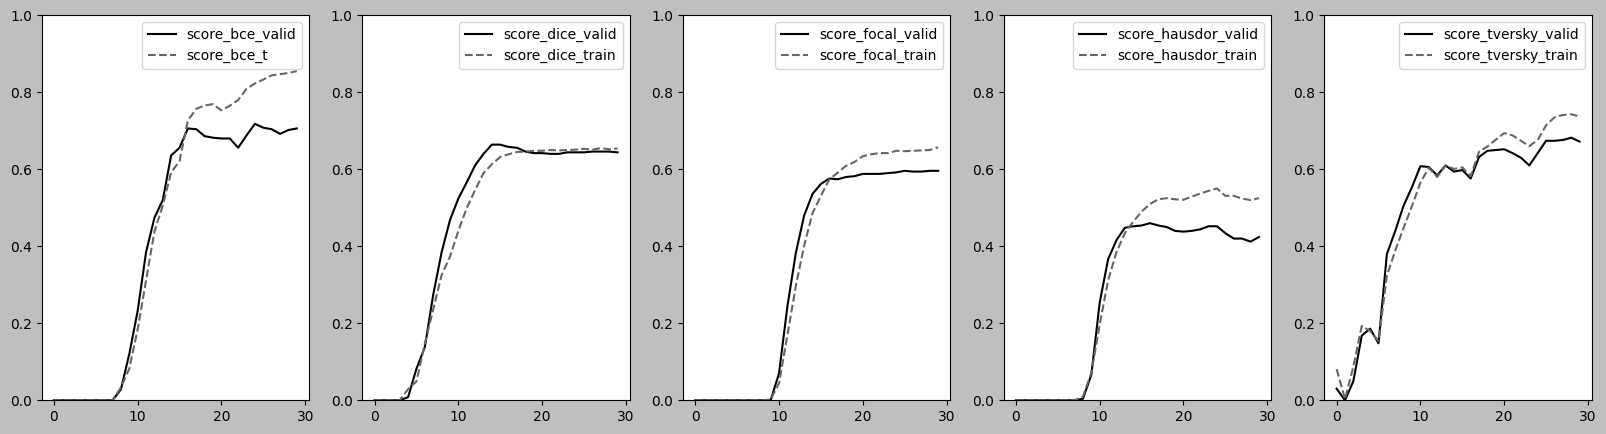

In [ ]:
fig = plt.figure(figsize = (20, 5))
ax1 = fig.add_subplot(151)
plt.plot(score_v_bce, label="score_bce_valid")
plt.plot(score_t_bce, label="score_bce_t",linestyle='dashed')
plt.ylim([0,1])
plt.legend()

ax1 = fig.add_subplot(152)
plt.plot(score_v_dice, label="score_dice_valid")
plt.plot(score_t_dice, label="score_dice_train", linestyle='dashed')
plt.ylim([0,1])
plt.legend()

ax1 = fig.add_subplot(153)
plt.plot(score_v_focal, label="score_focal_valid")
plt.plot(score_t_focal, label="score_focal_train", linestyle='dashed')
plt.ylim([0,1])
plt.legend()

ax1 = fig.add_subplot(154)
plt.plot(score_v_hausdor, label="score_hausdor_valid")
plt.plot(score_t_hausdor, label="score_hausdor_train", linestyle='dashed')
plt.ylim([0,1])
plt.legend()

ax1 = fig.add_subplot(155)
plt.plot(score_v_tversky, label="score_tversky_valid")
plt.plot(score_t_tversky, label="score_tversky_train", linestyle='dashed')
score_v_tversky, score_t_tversky
plt.ylim([0,1])
plt.legend()

plt.legend()
plt.show()



### Как можно отметить, лосс функции bce, dice и tversky показывают сравнимо хорошие результаты, однако dice значительно более стабильна, и у нее не так сильно выражены признаки переобучения.

### Далее выберем функцию лосса - bce: , и сравним нейросетевые архитектуры (для удобства будем смотреть score только на валидации)

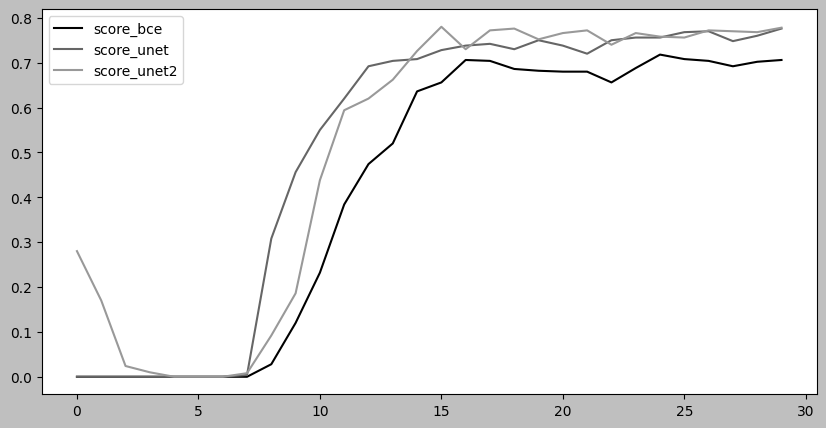

In [ ]:
fig = plt.figure(figsize = (10, 5))

plt.plot(score_v_bce, label="score_bce", )
plt.plot(score_v_unet, label="score_unet")
plt.plot(score_v_unet2, label="score_unet2")



plt.legend()
plt.show()

### UNet и UNet2 дают более высокую точность сегментации

### Теперь, для выбора наиболее точной модели я сравню модели архитектуры UNet и UNet2 с лосс функциями bce, dice, tversky.

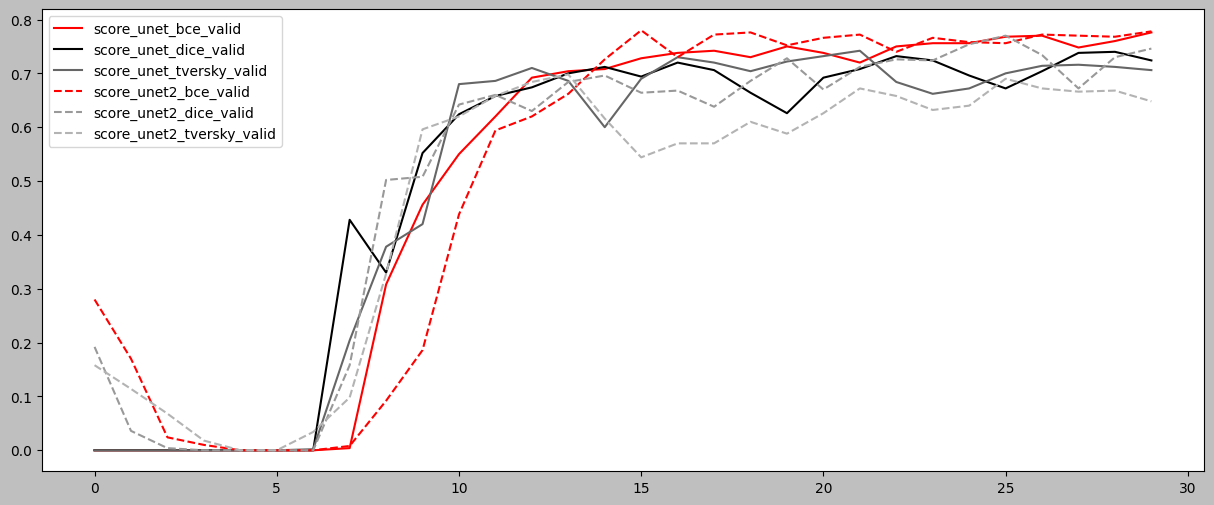

In [ ]:
fig = plt.figure(figsize = (15, 6))

plt.plot(score_v_unet, label="score_unet_bce_valid", color = 'r')
plt.plot(score_v_unet_dice, label="score_unet_dice_valid")
plt.plot(score_v_unet_tversky, label="score_unet_tversky_valid")
plt.plot(score_v_unet2, label="score_unet2_bce_valid", linestyle='dashed', color = 'r')
plt.plot(score_v_unet2_dice, label="score_unet2_dice_valid", linestyle='dashed')
plt.plot(score_v_unet2_tversky, label="score_unet2_tversky_valid", linestyle='dashed')

plt.grid
plt.legend()
plt.show()

### Обе архитектуры выдают наилучшую точность с лосс функцией bce. Попробуем поучить эти модели большее колличество эпох для определения разницы между ними.

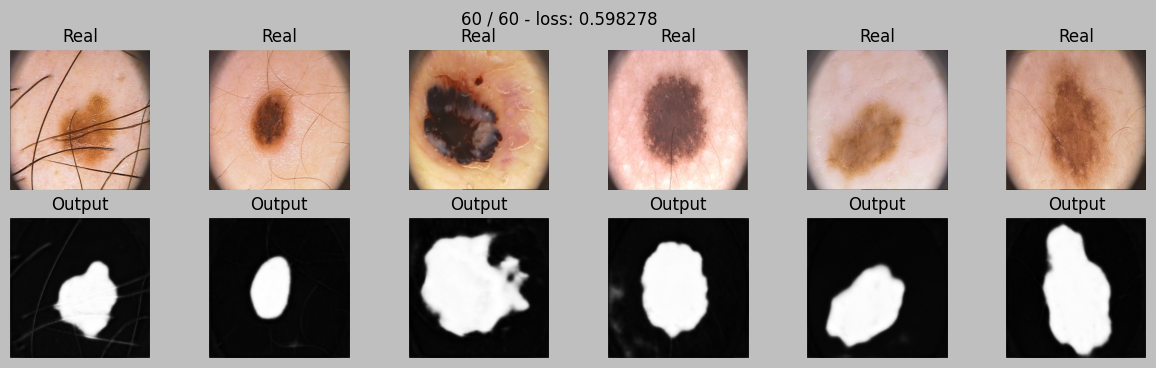

In [ ]:
unet2_model = UNet2().to(device)

max_epochs = 60
optim = torch.optim.Adam(unet2_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.95)

loss_t_unet2_2, loss_v_unet2_2, score_v_unet2_2, score_t_unet2_2 = train(unet2_model, optim, bce_loss, max_epochs, data_tr, data_val, scheduler,  score_model )

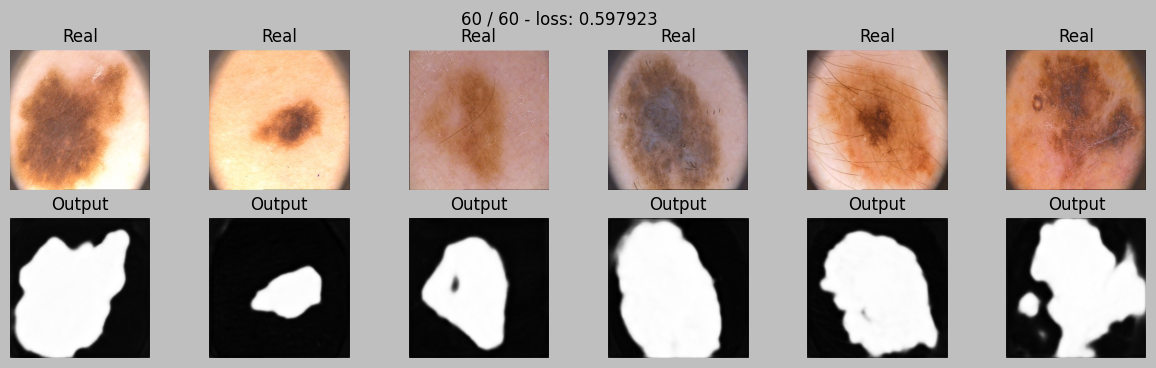

In [ ]:
unet_model = UNet().to(device)

max_epochs = 60
optim = torch.optim.Adam(unet_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.95)

loss_t_unet_2, loss_v_unet_2, score_v_unet_2, score_t_unet_2 = train(unet_model, optim, bce_loss, max_epochs, data_tr, data_val, scheduler,  score_model )

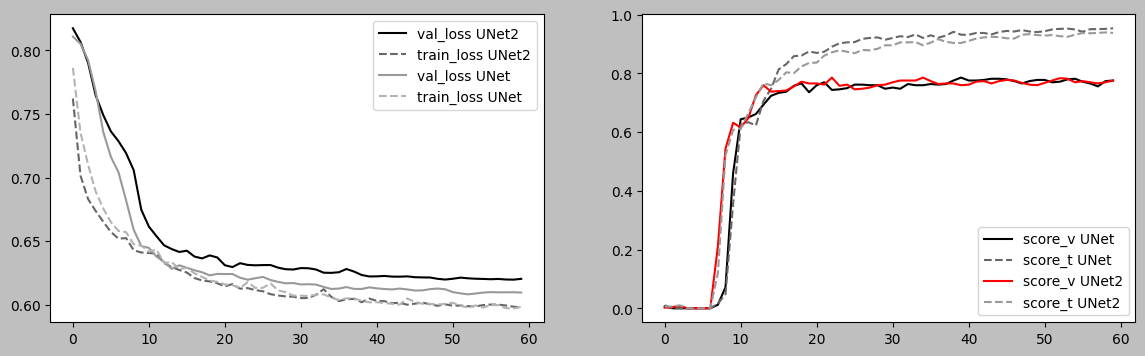

лучший score на валидационной выборке UNen: 0.7860000133514404 
 лучший score на валидационной выборке UNen2: 0.785999983549118


In [ ]:
from matplotlib.projections import Axes3D
fig = plt.figure(figsize = (14, 4))
ax1 = fig.add_subplot(121)
plt.plot(loss_v_unet_2, label="val_loss UNet2")
plt.plot(loss_t_unet_2, label="train_loss UNet2", linestyle='dashed')
plt.plot(loss_v_unet2_2, label="val_loss UNet")
plt.plot(loss_t_unet2_2, label="train_loss UNet", linestyle='dashed')

plt.legend()
ax2 = fig.add_subplot(122)
plt.plot(score_v_unet_2, label="score_v UNet", )
plt.plot(score_t_unet_2, label="score_t UNet", linestyle='dashed')
plt.plot(score_v_unet2_2, label="score_v UNet2", color = 'r')
plt.plot(score_t_unet2_2, label="score_t UNet2", linestyle='dashed')


plt.legend()

plt.show()
score_1 = max(score_v_unet_2)
score_2 = max(score_v_unet2_2)
print(f'лучший score на валидационной выборке UNen: {score_1}', '\n', f'лучший score на валидационной выборке UNen2: {score_2}')



# Обе архитектуры дают примерно одно и то же качество на валидации. В целом, их поведение очень похоже, так что я не могу отдать предпочтение какой-то одной. Лучшее качество сегментации на валидационной выборке: 0.786 